## NBA PREDICT W/L Local Team - Estadísticas 4 Factors + Algunas Tradicionales.
- Primero hay que lanzar el proceso que importa a partir de la api "nba_api", los datos de cada partido de la NBA en la temporada regular en curso o última que se jugo, en caso de que no se parametrice el valor de "Seanson=" de los metodos utilizados.  **C:\Users\RubenGA\WorkSpaces_rga01\Python\Scripts\NBA_g4factors_ETLscript_00.py**
- Los datos se transforman para tener una sola fila por cada game con información general del partido y los datos continuos que son algunas estadiscticas generales del partido + los 4 factores dferenciando local y visitante (var.predictoras continuas..), y se incluye tb la var.objetivo a predecir que es xa este caso, si el equipo local gana o no (W/L)(En el conjunto de datos tb esta el W/L del equipo visitante, x si en algunos casos o xa algunos algoritmos fuese mejor esa var.Objetivo..)
- Se realizará un EDA de los Datos, y si fuese necesario se cambiará el tipo o clase de algún atributo que no haya reconocido pandas, y asi observar y analizar los datos con detenimiento.
- En función de las necesidades se aplicarán técnicas de Ingenieria de carácteristicas y redución de dimensionalidad (PCA,UMAP..), para observar como se comportan las variables predictoras en función de la var.objetivo o no, y contemplanto las métricas de tendencia central las cuales se utilizan para aplicar determinadas teorías estadísticas
- Se aplicarán algoritmos de Clasificación Supervisada con diferentes técnicas para poder comparar y evaluar los modelos de ML.

In [49]:
# Importando librerias
import pandas as pd
import numpy as np
import time
import os
from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


In [2]:
# Permanently changes the pandas settings
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

os.getcwd()

'C:\\Users\\RubenGA\\WorkSpaces_rga01\\Python\\Notebooks\\Practicas_NBA'

### DATOS - Proceso mediante script python "NBA_Practica_00.py" con NBA_API utilizando varios metodos (endpoints).
- endpoints.leaguegamelog.LeagueGameLog().get_data_frames()[0] IDs y stats Tradicionales de los GAMES (Temporada Regular última o actual..al no dar valor a los parámetros de entrada del método).
- endpoints.boxscorefourfactorsv2.BoxScoreFourFactorsV2(game_id=ind_idgame), Bucle for para obtener las estadisticas de 4factors de cada partido de la temporada regular.
- Se realizan tranformaciones a los datos recuperados para UNIR, quitar y renombrar columnas..etc, y dejar el conjunto de datos lo más entendible posible dentro del contexto de a que hacen referencia los datos, en este caso reflejan un tipo de estadísticas generales por cada equipo que se enfrenta en cada game de la temporada, diferenciando en la misma fila las stats del team local(_l) y el visitante(_v), y si gana o pierde el equipo local (WL_l) y el visitante (WL_v)
    - Transformaciones importantes: Los 2 métodos de la api utilizados te devuelven 2 filas por cada Game una xa el equipo local y otra xa el quipo visitante, x lo que hay que utilizar técnicas para convertir en una sola fila sin perder información importante.
- Tras tener los datos listos para explotar, se exportan a un fichero csv, para no sobrecargar la api..
df_games4factors_1lineXgames.to_csv('C:/Users/RubenGA/WorkSpaces_rga01/Python/Data/df_games_4factors_clean1linesXgames_2021-22.csv')

In [3]:
# C:/Users/RubenGA/WorkSpaces_rga01/Python/Data/df_games_4factors_clean1linesXgames_2021-22.csv
# path = "/Python/Data/"
path = "C:/Users/RubenGA/WorkSpaces_rga01/Python/Data/"
file = "df_games_4factors_clean1linesXgames_2021-22.csv"
df_00 = pd.read_csv(path+file, index_col=0)
df_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230 entries, 0 to 1229
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GAME_ID              1230 non-null   int64  
 1   SEASON_ID            1230 non-null   int64  
 2   TEAM_ID_l            1230 non-null   int64  
 3   TEAM_ID_v            1230 non-null   int64  
 4   TEAM_ABBREVIATION_l  1230 non-null   object 
 5   TEAM_NAME_l          1230 non-null   object 
 6   TEAM_ABBREVIATION_v  1230 non-null   object 
 7   TEAM_NAME_v          1230 non-null   object 
 8   GAME_DATE            1230 non-null   object 
 9   MATCHUP              1230 non-null   object 
 10  WL_l                 1230 non-null   object 
 11  WL_v                 1230 non-null   object 
 12  PTS_l                1230 non-null   int64  
 13  PTS_v                1230 non-null   int64  
 14  EFG_PCT_l            1230 non-null   float64
 15  FTA_RATE_l           1230 non-null   f

In [4]:
df_00.head()

GAME_ID  SEASON_ID   TEAM_ID_l   TEAM_ID_v TEAM_ABBREVIATION_l  \
0  22100001      22021  1610612749  1610612751                 MIL   
1  22100002      22021  1610612747  1610612744                 LAL   
2  22100003      22021  1610612766  1610612754                 CHA   
3  22100004      22021  1610612765  1610612741                 DET   
4  22100005      22021  1610612752  1610612738                 NYK   

          TEAM_NAME_l TEAM_ABBREVIATION_v            TEAM_NAME_v   GAME_DATE  \
0     Milwaukee Bucks                 BKN          Brooklyn Nets  2021-10-19   
1  Los Angeles Lakers                 GSW  Golden State Warriors  2021-10-19   
2   Charlotte Hornets                 IND         Indiana Pacers  2021-10-20   
3     Detroit Pistons                 CHI          Chicago Bulls  2021-10-20   
4     New York Knicks                 BOS         Boston Celtics  2021-10-20   

       MATCHUP WL_l WL_v  PTS_l  PTS_v  EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  \
0  MIL vs. BKN    W    L    127    104      0.538       0.171         0.074   
1  LAL vs. GSW    L    W    114    121      0.553       0.200         0.155   
2  CHA vs. IND    W    L    123    122      0.491       0.252         0.070   
3  DET vs. CHI    L    W     88     94      0.433       0.144         0.167   
4  NYK vs. BOS    W    L    138    134      0.567       0.257         0.147   

   OREB_PCT_l  OPP_EFG_PCT_l  OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  \
0       0.224          0.542           0.274          0.127           0.176   
1       0.094          0.516           0.323          0.149           0.241   
2       0.182          0.561           0.267          0.155           0.255   
3       0.193          0.471           0.174          0.169           0.260   
4       0.123          0.500           0.197          0.138           0.296   

   FG_PCT_l  FG3_PCT_l  FT_PCT_l  OREB_l  DREB_l  AST_l  STL_l  BLK_l  TOV_l  \
0     0.457      0.378     0.778      13      41     25      8      9      8   
1     0.474      0.357     0.474       5      40     21      7      4     18   
2     0.430      0.419     0.667      12      34     29      9      5      8   
3     0.400      0.214     0.769      11      36     17      7      5     17   
4     0.486      0.378     0.704       7      48     27      9     10     19   

   PF_l  EFG_PCT_v  FTA_RATE_v  TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  \
0    19      0.542       0.274         0.127       0.098          0.538   
1    25      0.516       0.323         0.149       0.167          0.553   
2    21      0.561       0.267         0.155       0.157          0.491   
3    16      0.471       0.174         0.169       0.180          0.433   
4    22      0.500       0.197         0.138       0.211          0.567   

   OPP_FTA_RATE_v  OPP_TOV_PCT_v  OPP_OREB_PCT_v  FG_PCT_v  FG3_PCT_v  \
0           0.171          0.074           0.293     0.440      0.531   
1           0.200          0.155           0.189     0.441      0.359   
2           0.252          0.070           0.333     0.467      0.362   
3           0.144          0.167           0.263     0.430      0.304   
4           0.257          0.147           0.281     0.410      0.368   

   FT_PCT_v  OREB_v  DREB_v  AST_v  STL_v  BLK_v  TOV_v  PF_v  
0     0.565       5      39     19      3      9     13    17  
1     0.833       9      41     30      9      2     17    18  
2     0.875       8      43     29      2     10     17    24  
3     0.867       9      39     18      8      5     17    19  
4     0.739      15      41     34     13      9     18    24

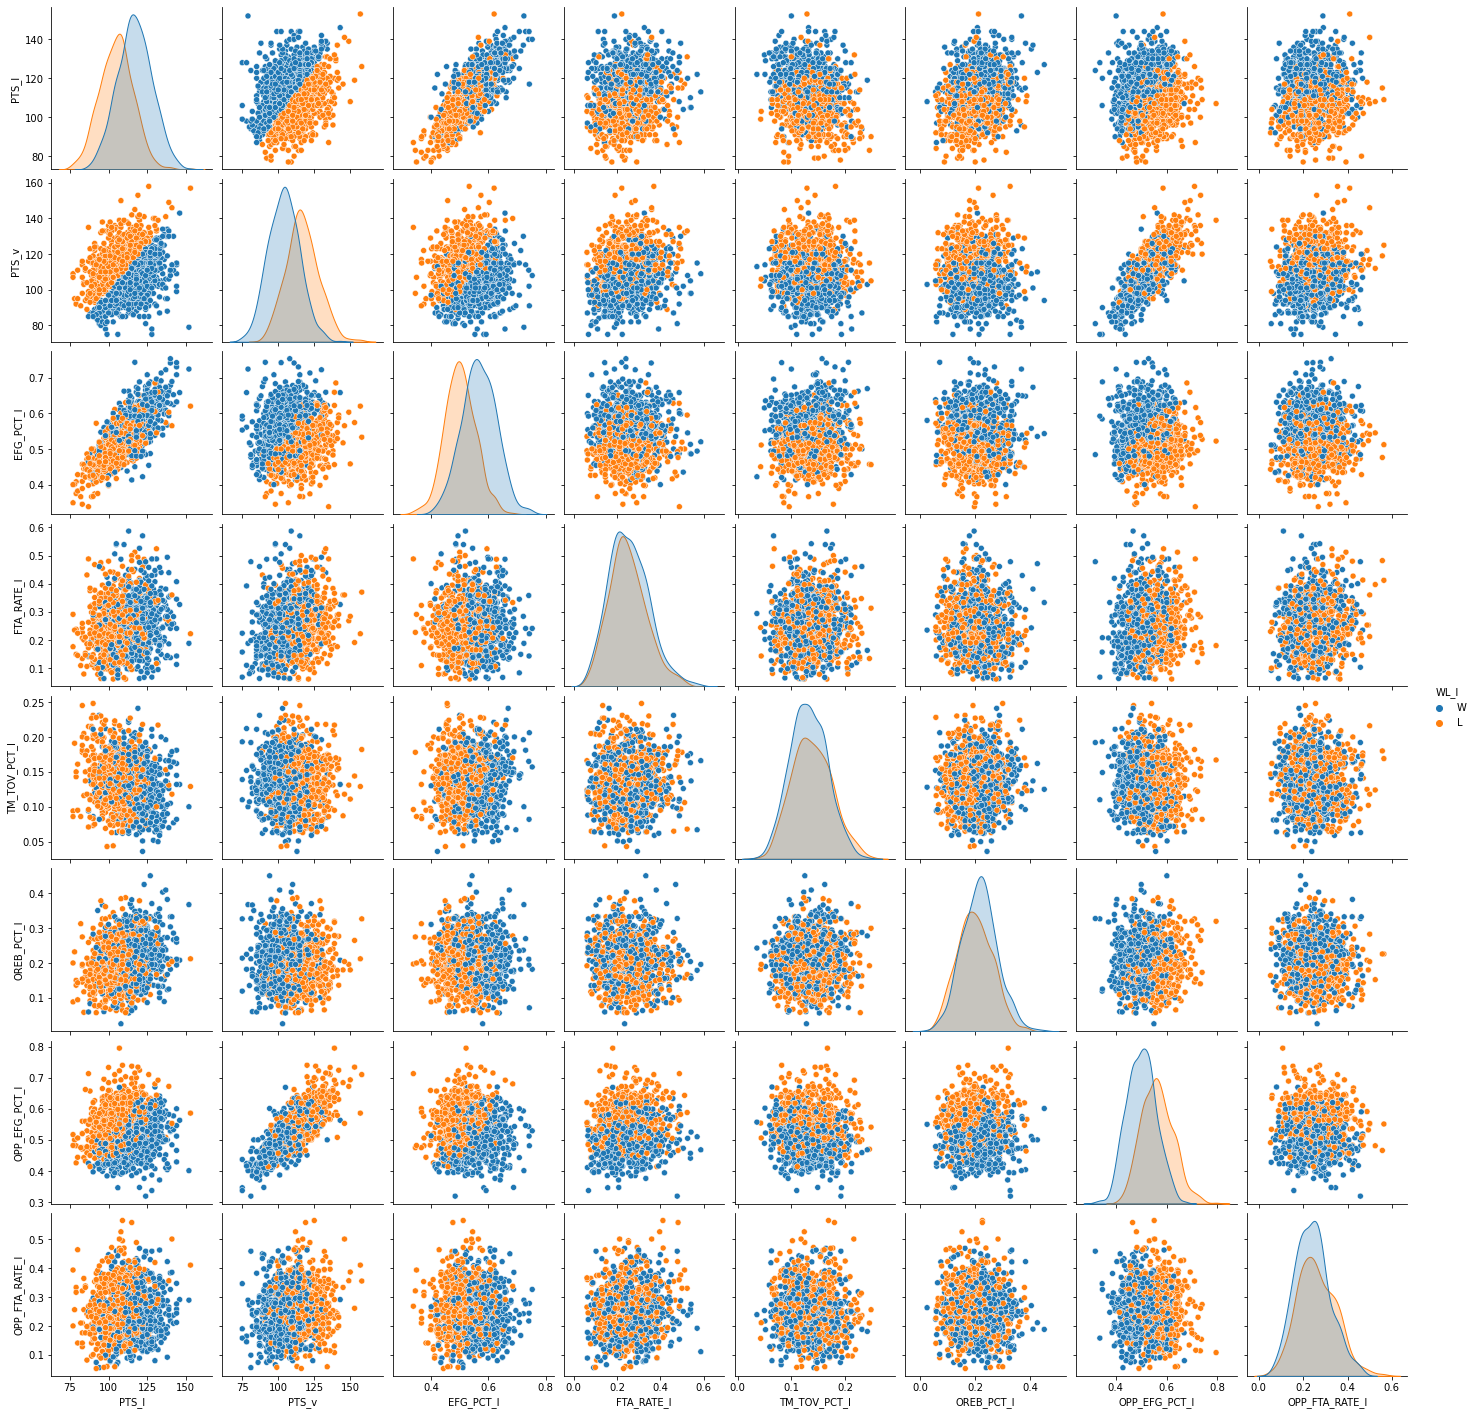

In [5]:
sb.pairplot(df_00.iloc[:,10:20], hue='WL_l')

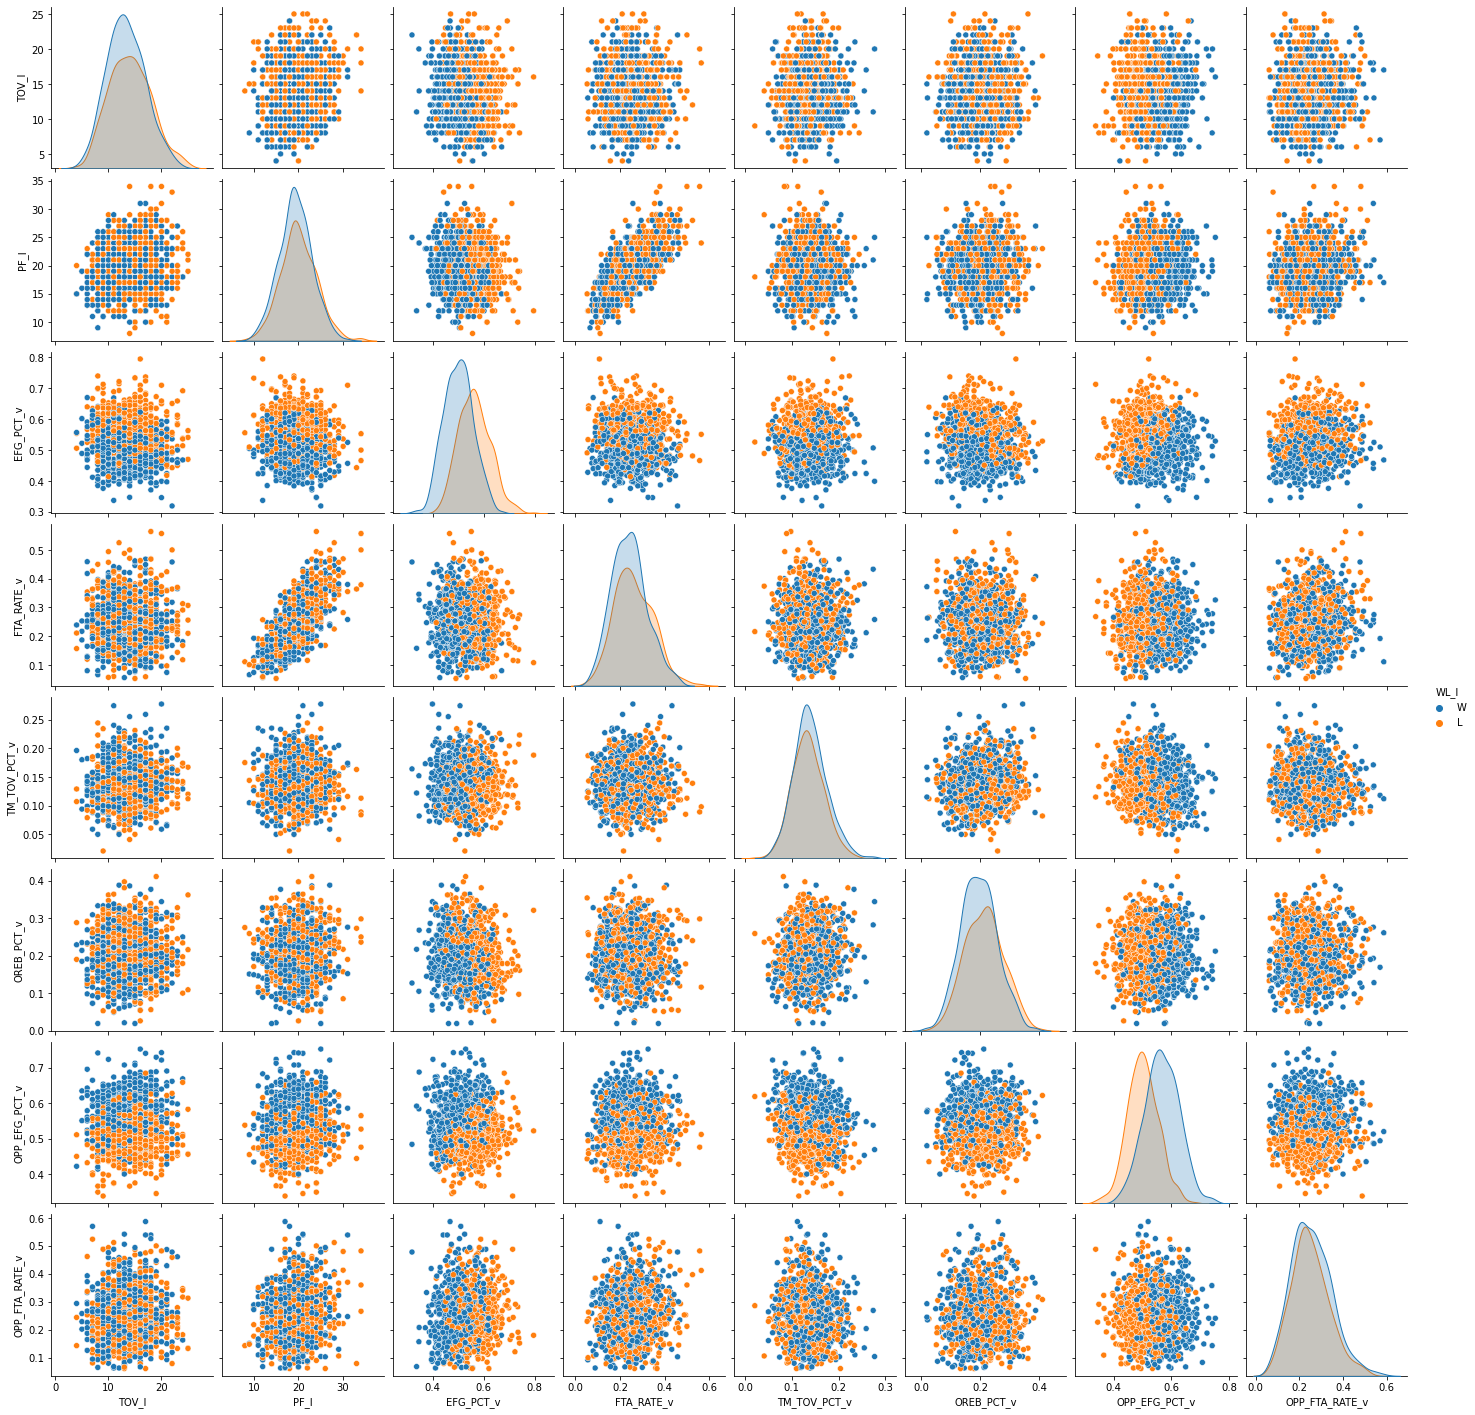

In [6]:
sb.pairplot(df_00.iloc[:,[10,30,31,32,33,34,35,36,37]], hue='WL_l')

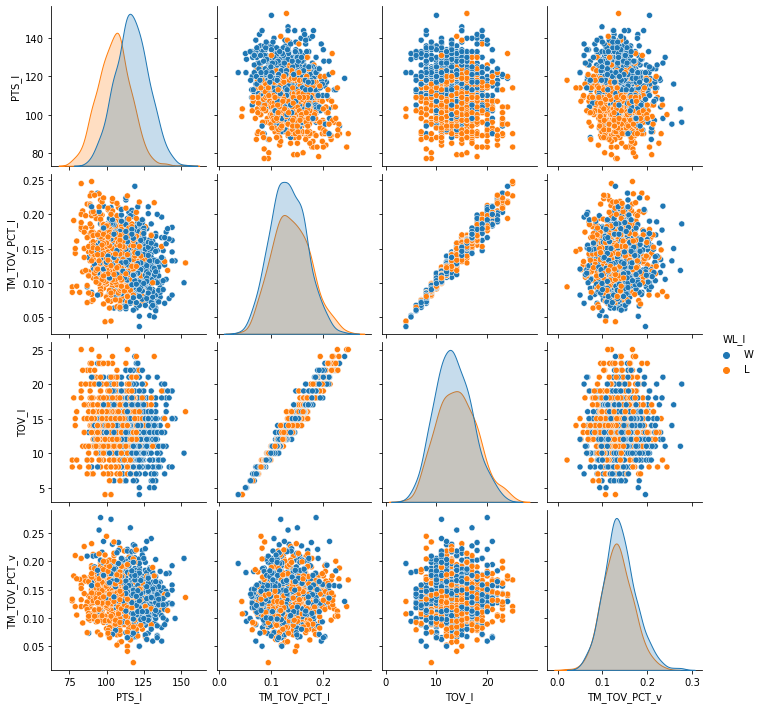

In [7]:
sb.pairplot(df_00.iloc[:,[10,12,16,30,34]], hue='WL_l')

## MACHINE LEARNING - Clasificación Supervisada.
### DEFINIENDO LOS DATOS DE TRAIN Y TEST.

In [8]:
# Definiendo las var.predictoras(Solo estadisticas 4factors) y la var.Objetivo

X = df_00.iloc[:,[14,15,16,17,18,19,20,21,32,33,34,35,36,37,38,39]]
y = df_00.WL_l

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=5)
print(X_train.shape,'-',y_train.shape)
print(X_test.shape,'-',y_test.shape)

(984, 16) - (984,)
(246, 16) - (246,)


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230 entries, 0 to 1229
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EFG_PCT_l       1230 non-null   float64
 1   FTA_RATE_l      1230 non-null   float64
 2   TM_TOV_PCT_l    1230 non-null   float64
 3   OREB_PCT_l      1230 non-null   float64
 4   OPP_EFG_PCT_l   1230 non-null   float64
 5   OPP_FTA_RATE_l  1230 non-null   float64
 6   OPP_TOV_PCT_l   1230 non-null   float64
 7   OPP_OREB_PCT_l  1230 non-null   float64
 8   EFG_PCT_v       1230 non-null   float64
 9   FTA_RATE_v      1230 non-null   float64
 10  TM_TOV_PCT_v    1230 non-null   float64
 11  OREB_PCT_v      1230 non-null   float64
 12  OPP_EFG_PCT_v   1230 non-null   float64
 13  OPP_FTA_RATE_v  1230 non-null   float64
 14  OPP_TOV_PCT_v   1230 non-null   float64
 15  OPP_OREB_PCT_v  1230 non-null   float64
dtypes: float64(16)
memory usage: 195.6 KB


### LOGISTIC REGRESSION.

In [10]:
mod_lr = LogisticRegression().fit(X_train,y_train)

y_predict_01 = mod_lr.predict(X_test)
y_predict_001 = mod_lr.predict(X_train)

print('Precisión - Test:',accuracy_score(y_predict_01,y_test))
print('Precisión - Train:',accuracy_score(y_predict_001,y_train))

# Son buenos resultados, pero habría que relizar pruebas o aplicar técnicas por si pudiera existir Overfiting..

Precisión - Test: 0.9186991869918699
Precisión - Train: 0.9166666666666666


In [11]:
print(confusion_matrix(y_predict_01,y_test))
print(confusion_matrix(y_predict_001,y_train))

[[ 97   3]
 [ 17 129]]
[[389  24]
 [ 58 513]]


<AxesSubplot:>

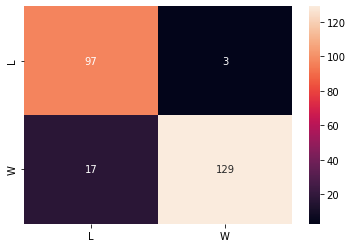

In [12]:
sb.heatmap(confusion_matrix(y_predict_01,y_test), annot=True, fmt='d', xticklabels=mod_lr.classes_, yticklabels=mod_lr.classes_)
# En esta representación en el eje de la Y (La predicción del Modelo), y en el eje X (El valor real del conjunto Test)

C:\Users\RubenGA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


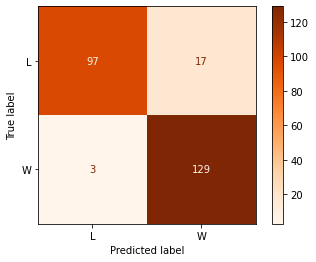

In [13]:
plot_confusion_matrix(mod_lr, X_test, y_test, display_labels=mod_lr.classes_, cmap=plt.cm.Oranges)

#### PRUEBAS SOBRE LOS MÉTODOS DEL OBJETO Linear Regression.

In [14]:
pd.DataFrame(mod_lr.predict_proba(X_test), columns=mod_lr.classes_)
# El método predict_proba refleja el % de probabilidad que el modelo otorga a cada una de las categorias de la var.objetivo,
# en este caso binaria y significando lo siguiente L(local Lost), W(Local Win)

L         W
0    0.653607  0.346393
1    0.924655  0.075345
2    0.606798  0.393202
3    0.701886  0.298114
4    0.701419  0.298581
..        ...       ...
241  0.498269  0.501731
242  0.324754  0.675246
243  0.627262  0.372738
244  0.765836  0.234164
245  0.196451  0.803549

[246 rows x 2 columns]

In [15]:
print(zip(y_test,y_predict_01))

In [16]:
pd.DataFrame(zip(y_test,y_predict_01),columns=['Real','Predict'])

Real Predict
0      L       L
1      L       L
2      L       L
3      L       L
4      L       L
..   ...     ...
241    L       W
242    W       W
243    L       L
244    L       L
245    W       W

[246 rows x 2 columns]

In [17]:
pd.DataFrame(pd.crosstab(y_test,y_predict_01))

col_0   L    W
WL_l          
L      97   17
W       3  129

#### PRUEBAS SOBRE EL CONTEXTO DE LOS DATOS..

In [82]:
# Para cambiar el formato de visualización de los números de las variables de un dataFrames
pd.set_option('display.float_format', '{:2f}'.format)

# ***LOS CAMPOS COMO IDs, AÑOS(q no estan en formato fecha) AL AGRUPAR Y CALCULAR UNA FUN DE AGREGACIÓN Y AL HABERLOS DEJADO 
# COMO NÚMEROS, SE RECALCULAN Y APARECEN EN EL DF FINAL...AHBRIA Q CONVERTIRLOS EN "STR" PARA Q NO APAREZCAN EN AGREGACIONES..

# MEDIAS de equipos cuando juegan como local..y las medias de los equipos q les han jugado como visitante
print(len(df_00.groupby(by='TEAM_ID_l')))
df_00.groupby(by='TEAM_ID_l').mean().head()

30


GAME_ID    SEASON_ID         TEAM_ID_v      PTS_l  \
TEAM_ID_l                                                              
1610612737 22100604.707317 22021.000000 1610612751.804878 116.658537   
1610612738 22100619.536585 22021.000000 1610612752.439024 110.756098   
1610612739 22100630.853659 22021.000000 1610612752.195122 108.073171   
1610612740 22100633.048780 22021.000000 1610612751.951220 111.365854   
1610612741 22100617.073171 22021.000000 1610612752.048780 114.195122   

                PTS_v  EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  \
TEAM_ID_l                                                                
1610612737 111.682927   0.559976    0.276415      0.117390    0.196756   
1610612738 103.780488   0.539585    0.237268      0.137098    0.223268   
1610612739 103.658537   0.539927    0.265220      0.146683    0.211024   
1610612740 110.048780   0.529780    0.249610      0.138390    0.241683   
1610612741 111.780488   0.545927    0.252976      0.117512    0.194244   

            OPP_EFG_PCT_l  OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  \
TEAM_ID_l                                                                  
1610612737       0.540756        0.218268       0.131122        0.267634   
1610612738       0.508683        0.229439       0.142780        0.270537   
1610612739       0.513390        0.225024       0.140951        0.265049   
1610612740       0.548122        0.251756       0.140927        0.258537   
1610612741       0.542293        0.246659       0.125488        0.252244   

            FG_PCT_l  FG3_PCT_l  FT_PCT_l    OREB_l    DREB_l     AST_l  \
TEAM_ID_l                                                                 
1610612737  0.482902   0.380049  0.822122  9.341463 34.268293 25.195122   
1610612738  0.467390   0.351439  0.818756 10.902439 34.707317 24.512195   
1610612739  0.468220   0.358171  0.750610 10.219512 34.560976 25.414634   
1610612740  0.467024   0.331976  0.794927 12.146341 33.195122 25.853659   
1610612741  0.485659   0.373683  0.808585  9.317073 34.341463 24.292683   

              STL_l    BLK_l     TOV_l      PF_l  EFG_PCT_v  FTA_RATE_v  \
TEAM_ID_l                                                                 
1610612737 7.804878 4.609756 11.707317 18.926829   0.540756    0.218268   
1610612738 7.463415 5.682927 13.658537 18.000000   0.508683    0.229439   
1610612739 7.292683 4.243902 14.487805 17.512195   0.513390    0.225024   
1610612740 8.073171 4.000000 13.926829 19.780488   0.548122    0.251756   
1610612741 6.951220 4.073171 11.853659 18.341463   0.542293    0.246659   

            TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  OPP_FTA_RATE_v  \
TEAM_ID_l                                                             
1610612737      0.131122    0.206634       0.559976        0.276415   
1610612738      0.142780    0.199732       0.539585        0.237268   
1610612739      0.140951    0.207268       0.539927        0.265220   
1610612740      0.140927    0.197756       0.529780        0.249610   
1610612741      0.125488    0.179780       0.545927        0.252976   

            OPP_TOV_PCT_v  OPP_OREB_PCT_v  FG_PCT_v  FG3_PCT_v  FT_PCT_v  \
TEAM_ID_l                                                                  
1610612737       0.117390        0.258341  0.468537   0.365293  0.792024   
1610612738       0.137098        0.285561  0.440585   0.348488  0.795927   
1610612739       0.146683        0.276220  0.450024   0.329220  0.764439   
1610612740       0.138390        0.314634  0.471854   0.368293  0.779488   
1610612741       0.117512        0.254927  0.475244   0.363293  0.791878   

              OREB_v    DREB_v     AST_v    STL_v    BLK_v     TOV_v      PF_v  
TEAM_ID_l                                                                       
1610612737 10.414634 32.878049 24.853659 7.048780 4.024390 13.219512 21.121951  
1610612738 10.243902 32.902439 21.487805 7.682927 4.365854 14.268293 19.195122  
1610612739 10.390244 32.634146 24.560976 8.268293 4.073

In [19]:
# MEDIAS de equipos cuando juegan como visitante..y las medias de todos los eqquipos que les han jugado como local
df_00.groupby(by='TEAM_ID_v').mean().head()

GAME_ID  SEASON_ID     TEAM_ID_l       PTS_l       PTS_v  \
TEAM_ID_v                                                                   
1610612737  2.210062e+07    22021.0  1.610613e+09  113.073171  111.219512   
1610612738  2.210060e+07    22021.0  1.610613e+09  105.170732  112.756098   
1610612739  2.210058e+07    22021.0  1.610613e+09  107.682927  107.512195   
1610612740  2.210059e+07    22021.0  1.610613e+09  110.512195  107.219512   
1610612741  2.210061e+07    22021.0  1.610613e+09  112.219512  109.024390   

            EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  OPP_EFG_PCT_l  \
TEAM_ID_v                                                                    
1610612737   0.548439    0.233000      0.123049    0.202780       0.529122   
1610612738   0.496707    0.244951      0.132000    0.199024       0.546829   
1610612739   0.526341    0.226439      0.130122    0.207878       0.536610   
1610612740   0.549171    0.252024      0.142707    0.184268       0.507756   
1610612741   0.542098    0.260756      0.133220    0.202463       0.536634   

            OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  FG_PCT_l  \
TEAM_ID_v                                                             
1610612737        0.234073       0.119707        0.273317  0.476098   
1610612738        0.244732       0.135829        0.265732  0.430000   
1610612739        0.261122       0.145488        0.272561  0.455415   
1610612740        0.284220       0.141098        0.291634  0.472902   
1610612741        0.246415       0.137000        0.240049  0.474683   

            FG3_PCT_l  FT_PCT_l     OREB_l     DREB_l      AST_l     STL_l  \
TEAM_ID_v                                                                    
1610612737   0.363390  0.800244  10.024390  34.390244  26.000000  7.000000   
1610612738   0.328512  0.769488  10.682927  33.609756  21.756098  7.390244   
1610612739   0.376488  0.772683  10.536585  32.170732  23.682927  8.585366   
1610612740   0.361293  0.803707   8.707317  33.487805  25.512195  7.243902   
1610612741   0.364366  0.809244   9.878049  33.878049  24.902439  7.341463   

               BLK_l      TOV_l       PF_l  EFG_PCT_v  FTA_RATE_v  \
TEAM_ID_v                                                           
1610612737  4.926829  12.292683  19.560976   0.529122    0.234073   
1610612738  4.804878  13.365854  19.634146   0.546829    0.244732   
1610612739  5.195122  12.926829  19.902439   0.536610    0.261122   
1610612740  5.390244  14.341463  21.000000   0.507756    0.284220   
1610612741  4.682927  13.439024  18.073171   0.536634    0.246415   

            TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  OPP_FTA_RATE_v  \
TEAM_ID_v                                                             
1610612737      0.119707    0.210049       0.548439        0.233000   
1610612738      0.135829    0.206707       0.496707        0.244951   
1610612739      0.145488    0.214024       0.526341        0.226439   
1610612740      0.141098    0.229341       0.549171        0.252024   
1610612741      0.137000    0.171341       0.542098        0.260756   

            OPP_TOV_PCT_v  OPP_OREB_PCT_v  FG_PCT_v  FG3_PCT_v  FT_PCT_v  \
TEAM_ID_v                                                                  
1610612737       0.123049        0.263537  0.459366   0.363439  0.801415   
1610612738       0.132000        0.274488  0.466780   0.353439  0.814220   
1610612739       0.130122        0.282171  0.471122   0.347463  0.782805   
1610612740       0.142707        0.248610  0.448878   0.339146  0.784610   
1610612741       0.133220        0.270976  0.474854   0.359317  0.808634   

               OREB_v     DREB_v      AST_v     STL_v     BLK_v      TOV_v  \
TEAM_ID_v                                                                    
1610612737  10.731707  33.609756  24.000000  6.512195  3.878049  12.000000   
1610612738  10.146341  36.390244  25.146341  6.951220  5.975610  13.609756   
1610612739  10.195122  33.390244  24.926829  6.853659  4.1

In [20]:
# MEDIAS TOTALES...de todos los equipos
((df_00.groupby(by='TEAM_ID_l').mean() + df_00.groupby(by='TEAM_ID_v').mean()) / 2).head()

AST_l      AST_v     BLK_l     BLK_v     DREB_l     DREB_v  \
TEAM_ID_l                                                                    
1610612737  25.597561  24.426829  4.768293  3.951220  34.329268  33.243902   
1610612738  23.134146  23.317073  5.243902  5.170732  34.158537  34.646341   
1610612739  24.548780  24.743902  4.719512  4.097561  33.365854  33.012195   
1610612740  25.682927  24.146341  4.695122  4.073171  33.341463  32.414634   
1610612741  24.597561  24.268293  4.378049  4.719512  34.109756  33.414634   

            EFG_PCT_l  EFG_PCT_v  FG3_PCT_l  FG3_PCT_v  FG_PCT_l  FG_PCT_v  \
TEAM_ID_l                                                                    
1610612737   0.554207   0.534939   0.371720   0.364366  0.479500  0.463951   
1610612738   0.518146   0.527756   0.339976   0.350963  0.448695  0.453683   
1610612739   0.533134   0.525000   0.367329   0.338341  0.461817  0.460573   
1610612740   0.539476   0.527939   0.346634   0.353720  0.469963  0.460366   
1610612741   0.544012   0.539463   0.369024   0.361305  0.480171  0.475049   

            FTA_RATE_l  FTA_RATE_v  FT_PCT_l  FT_PCT_v       GAME_ID  \
TEAM_ID_l                                                              
1610612737    0.254707    0.226171  0.811183  0.796720  2.210061e+07   
1610612738    0.241110    0.237085  0.794122  0.805073  2.210061e+07   
1610612739    0.245829    0.243073  0.761646  0.773622  2.210060e+07   
1610612740    0.250817    0.267988  0.799317  0.782049  2.210061e+07   
1610612741    0.256866    0.246537  0.808915  0.800256  2.210062e+07   

            OPP_EFG_PCT_l  OPP_EFG_PCT_v  OPP_FTA_RATE_l  OPP_FTA_RATE_v  \
TEAM_ID_l                                                                  
1610612737       0.534939       0.554207        0.226171        0.254707   
1610612738       0.527756       0.518146        0.237085        0.241110   
1610612739       0.525000       0.533134        0.243073        0.245829   
1610612740       0.527939       0.539476        0.267988        0.250817   
1610612741       0.539463       0.544012        0.246537        0.256866   

            OPP_OREB_PCT_l  OPP_OREB_PCT_v  OPP_TOV_PCT_l  OPP_TOV_PCT_v  \
TEAM_ID_l                                                                  
1610612737        0.270476        0.260939       0.125415       0.120220   
1610612738        0.268134        0.280024       0.139305       0.134549   
1610612739        0.268805        0.279195       0.143220       0.138402   
1610612740        0.275085        0.281622       0.141012       0.140549   
1610612741        0.246146        0.262951       0.131244       0.125366   

            OREB_PCT_l  OREB_PCT_v     OREB_l     OREB_v       PF_l  \
TEAM_ID_l                                                             
1610612737    0.199768    0.208341   9.682927  10.573171  19.243902   
1610612738    0.211146    0.203220  10.792683  10.195122  18.817073   
1610612739    0.209451    0.210646  10.378049  10.292683  18.707317   
1610612740    0.212976    0.213549  10.426829  10.792683  20.390244   
1610612741    0.198354    0.175561   9.597561   8.390244  18.207317   

                 PF_v       PTS_l       PTS_v  SEASON_ID     STL_l     STL_v  \
TEAM_ID_l                                                                      
1610612737  19.804878  114.865854  111.451220    22021.0  7.402439  6.780488   
1610612738  19.146341  107.963415  108.268293    22021.0  7.426829  7.317073   
1610612739  18.743902  107.878049  105.585366    22021.0  7.939024  7.560976   
1610612740  19.768293  110.939024  108.634146    22021.0  7.658537  8.012195   
1610612741  18.731707  113.207317  110.402439    22021.0  7.146341  7.109756   

            TEAM_ID_l  TEAM_ID_v  TM_TOV_PCT_l  TM_TOV_PCT_v      TOV_l  \
TEAM_ID_l                                                                 
1610612737        NaN        NaN      0.120220      0.125415  12.000000   
1610612738        NaN        NaN      0.134549      0.139305  13.51

In [84]:
# Calculos de las ASISTENCIAS "PER GAME", de cada equipo...MIsmo resultado que en el Aplicativo WEB
(df_00.groupby(by='TEAM_ID_l').mean()['AST_l'] + df_00.groupby(by='TEAM_ID_v').mean()['AST_v']) / 2

TEAM_ID_l
1610612737   24.597561
1610612738   24.829268
1610612739   25.170732
1610612740   24.963415
1610612741   23.878049
1610612742   23.390244
1610612743   27.792683
1610612744   27.109756
1610612745   23.560976
1610612746   24.012195
1610612747   24.000000
1610612748   25.487805
1610612749   23.902439
1610612750   25.682927
1610612751   25.256098
1610612752   21.865854
1610612753   23.743902
1610612754   25.378049
1610612755   23.719512
1610612756   27.365854
1610612757   22.926829
1610612758   23.695122
1610612759   27.914634
1610612760   22.219512
1610612761   22.060976
1610612762   22.390244
1610612763   25.987805
1610612764   25.024390
1610612765   23.463415
1610612766   28.073171
dtype: float64

In [21]:
# Obtener medias de las estadisticas del conjunto de datos de cada equipo en temp.regular en función de si juegan de local
# visitante..
# Solo un Equipo..
print(len(df_00.groupby(by='TEAM_ID_l')))
df_00[df_00.TEAM_ID_l == 1610612756].groupby(by='TEAM_ID_l').mean()

30


GAME_ID  SEASON_ID     TEAM_ID_v       PTS_l       PTS_v  \
TEAM_ID_l                                                                   
1610612756  2.210059e+07    22021.0  1.610613e+09  115.463415  106.585366   

            EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  OPP_EFG_PCT_l  \
TEAM_ID_l                                                                    
1610612756   0.558244    0.225537      0.129976    0.210463       0.507268   

            OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  FG_PCT_l  \
TEAM_ID_l                                                             
1610612756        0.247976       0.138829        0.268878  0.490805   

            FG3_PCT_l  FT_PCT_l     OREB_l     DREB_l     AST_l    STL_l  \
TEAM_ID_l                                                                  
1610612756   0.373293  0.776098  10.170732  36.073171  27.97561  8.04878   

               BLK_l      TOV_l       PF_l  EFG_PCT_v  FTA_RATE_v  \
TEAM_ID_l                                                           
1610612756  4.902439  13.170732  19.243902   0.507268    0.247976   

            TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  OPP_FTA_RATE_v  \
TEAM_ID_l                                                             
1610612756      0.138829    0.196341       0.558244        0.225537   

            OPP_TOV_PCT_v  OPP_OREB_PCT_v  FG_PCT_v  FG3_PCT_v  FT_PCT_v  \
TEAM_ID_l                                                                  
1610612756       0.129976        0.267756  0.439585   0.344463  0.774878   

               OREB_v    DREB_v      AST_v     STL_v     BLK_v      TOV_v  \
TEAM_ID_l                                                                   
1610612756  10.341463  33.04878  22.731707  7.731707  3.926829  14.219512   

                 PF_v  
TEAM_ID_l              
1610612756  18.439024

In [22]:
df_00[df_00.TEAM_ID_v == 1610612756].groupby(by='TEAM_ID_v').mean()

GAME_ID  SEASON_ID     TEAM_ID_l       PTS_l       PTS_v  \
TEAM_ID_v                                                                   
1610612756  2.210067e+07    22021.0  1.610613e+09  108.073171  114.195122   

            EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  OPP_EFG_PCT_l  \
TEAM_ID_v                                                                    
1610612756   0.515049    0.271585       0.14778    0.210512       0.542146   

            OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  FG_PCT_l  \
TEAM_ID_v                                                             
1610612756        0.227366       0.123049         0.25378  0.450512   

            FG3_PCT_l  FT_PCT_l     OREB_l     DREB_l  AST_l     STL_l  \
TEAM_ID_v                                                                
1610612756   0.333146  0.746463  10.707317  34.829268   23.0  7.243902   

              BLK_l      TOV_l       PF_l  EFG_PCT_v  FTA_RATE_v  \
TEAM_ID_v                                                          
1610612756  4.04878  15.195122  19.439024   0.542146    0.227366   

            TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  OPP_FTA_RATE_v  \
TEAM_ID_v                                                             
1610612756      0.123049    0.187659       0.515049        0.271585   

            OPP_TOV_PCT_v  OPP_OREB_PCT_v  FG_PCT_v  FG3_PCT_v  FT_PCT_v  \
TEAM_ID_v                                                                  
1610612756        0.14778        0.273927   0.48061   0.355463  0.814512   

              OREB_v    DREB_v      AST_v     STL_v     BLK_v      TOV_v  \
TEAM_ID_v                                                                  
1610612756  9.365854  34.97561  26.756098  9.073171  3.853659  12.682927   

                 PF_v  
TEAM_ID_v              
1610612756  20.585366

In [23]:
# MEDIA GENERAL DE UN EQUIPO..
# OBteniendo la medias de un equipo jugando tanto como local como visitante
# (df_00[df_00.TEAM_ID_l == 1610612756].groupby(by='TEAM_ID_l').median().values + \
#  df_00[df_00.TEAM_ID_v == 1610612756].groupby(by='TEAM_ID_v').median().values) / 2
(df_00[df_00.TEAM_ID_l == 1610612756].groupby(by='TEAM_ID_l').mean() + \
 df_00[df_00.TEAM_ID_v == 1610612756].groupby(by='TEAM_ID_v').mean()) / 2

AST_l      AST_v    BLK_l     BLK_v    DREB_l     DREB_v  \
TEAM_ID_l                                                                  
1610612756  25.487805  24.743902  4.47561  3.890244  35.45122  34.012195   

            EFG_PCT_l  EFG_PCT_v  FG3_PCT_l  FG3_PCT_v  FG_PCT_l  FG_PCT_v  \
TEAM_ID_l                                                                    
1610612756   0.536646   0.524707    0.35322   0.349963  0.470659  0.460098   

            FTA_RATE_l  FTA_RATE_v  FT_PCT_l  FT_PCT_v       GAME_ID  \
TEAM_ID_l                                                              
1610612756    0.248561    0.237671   0.76128  0.794695  2.210063e+07   

            OPP_EFG_PCT_l  OPP_EFG_PCT_v  OPP_FTA_RATE_l  OPP_FTA_RATE_v  \
TEAM_ID_l                                                                  
1610612756       0.524707       0.536646        0.237671        0.248561   

            OPP_OREB_PCT_l  OPP_OREB_PCT_v  OPP_TOV_PCT_l  OPP_TOV_PCT_v  \
TEAM_ID_l                                                                  
1610612756        0.261329        0.270841       0.130939       0.138878   

            OREB_PCT_l  OREB_PCT_v     OREB_l    OREB_v       PF_l       PF_v  \
TEAM_ID_l                                                                       
1610612756    0.210488       0.192  10.439024  9.853659  19.341463  19.512195   

                 PTS_l       PTS_v  SEASON_ID     STL_l     STL_v  TEAM_ID_l  \
TEAM_ID_l                                                                      
1610612756  111.768293  110.390244    22021.0  7.646341  8.402439        NaN   

            TEAM_ID_v  TM_TOV_PCT_l  TM_TOV_PCT_v      TOV_l     TOV_v  
TEAM_ID_l                                                               
1610612756        NaN      0.138878      0.130939  14.182927  13.45122

In [24]:
# MEDIA GENERAL DE UN EQUIPO..***Comprobación con los resultados obtenidos por team_local y team_visitante..
# OBteniendo la medias de un equipo jugando tanto como local como visitante
# (df_00[df_00.TEAM_ID_l == 1610612756].groupby(by='TEAM_ID_l').median().values + \
#  df_00[df_00.TEAM_ID_v == 1610612756].groupby(by='TEAM_ID_v').median().values) / 2
(df_00[df_00.TEAM_ID_l == 1610612737].groupby(by='TEAM_ID_l').mean() + \
 df_00[df_00.TEAM_ID_v == 1610612737].groupby(by='TEAM_ID_v').mean()) / 2

AST_l      AST_v     BLK_l    BLK_v     DREB_l     DREB_v  \
TEAM_ID_l                                                                   
1610612737  25.597561  24.426829  4.768293  3.95122  34.329268  33.243902   

            EFG_PCT_l  EFG_PCT_v  FG3_PCT_l  FG3_PCT_v  FG_PCT_l  FG_PCT_v  \
TEAM_ID_l                                                                    
1610612737   0.554207   0.534939    0.37172   0.364366    0.4795  0.463951   

            FTA_RATE_l  FTA_RATE_v  FT_PCT_l  FT_PCT_v       GAME_ID  \
TEAM_ID_l                                                              
1610612737    0.254707    0.226171  0.811183   0.79672  2.210061e+07   

            OPP_EFG_PCT_l  OPP_EFG_PCT_v  OPP_FTA_RATE_l  OPP_FTA_RATE_v  \
TEAM_ID_l                                                                  
1610612737       0.534939       0.554207        0.226171        0.254707   

            OPP_OREB_PCT_l  OPP_OREB_PCT_v  OPP_TOV_PCT_l  OPP_TOV_PCT_v  \
TEAM_ID_l                                                                  
1610612737        0.270476        0.260939       0.125415        0.12022   

            OREB_PCT_l  OREB_PCT_v    OREB_l     OREB_v       PF_l       PF_v  \
TEAM_ID_l                                                                       
1610612737    0.199768    0.208341  9.682927  10.573171  19.243902  19.804878   

                 PTS_l      PTS_v  SEASON_ID     STL_l     STL_v  TEAM_ID_l  \
TEAM_ID_l                                                                     
1610612737  114.865854  111.45122    22021.0  7.402439  6.780488        NaN   

            TEAM_ID_v  TM_TOV_PCT_l  TM_TOV_PCT_v  TOV_l      TOV_v  
TEAM_ID_l                                                            
1610612737        NaN       0.12022      0.125415   12.0  12.609756

#### Prueba de Predicción sobre un Game supuestamente futuro..

In [25]:
df_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230 entries, 0 to 1229
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GAME_ID              1230 non-null   int64  
 1   SEASON_ID            1230 non-null   int64  
 2   TEAM_ID_l            1230 non-null   int64  
 3   TEAM_ID_v            1230 non-null   int64  
 4   TEAM_ABBREVIATION_l  1230 non-null   object 
 5   TEAM_NAME_l          1230 non-null   object 
 6   TEAM_ABBREVIATION_v  1230 non-null   object 
 7   TEAM_NAME_v          1230 non-null   object 
 8   GAME_DATE            1230 non-null   object 
 9   MATCHUP              1230 non-null   object 
 10  WL_l                 1230 non-null   object 
 11  WL_v                 1230 non-null   object 
 12  PTS_l                1230 non-null   int64  
 13  PTS_v                1230 non-null   int64  
 14  EFG_PCT_l            1230 non-null   float64
 15  FTA_RATE_l           1230 non-null   f

### Estadísticas relevantes que se pueden obtener de este conjuntos de datos con respecto a los 4factors..

In [26]:
# Team Local, solamente estadisticas medias relacionadas con la 4factors cuando el team juaga como local...y las medias
# de los equipos visitantes "OPP_xx"
df_00[df_00.TEAM_ID_l == 1610612756].groupby(by='TEAM_ID_l').mean().iloc[:, 5:13]

EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  OPP_EFG_PCT_l  \
TEAM_ID_l                                                                    
1610612756   0.558244    0.225537      0.129976    0.210463       0.507268   

            OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  
TEAM_ID_l                                                  
1610612756        0.247976       0.138829        0.268878

In [27]:
# NO sirve para el input de la predicción pero es buen dato informar como una metrica, las estadisticas medias de los 
# equipos contrarios, para este caso los equipos visitantes..cuando el equipo seleccionado juega como local..
# ***Que si nos fijamos coinciden con anterior filtro pero de manera inversa El efg_l = OPP_Efg_v...
df_00[df_00.TEAM_ID_l == 1610612756].groupby(by='TEAM_ID_l').mean().iloc[:, 23:31]

EFG_PCT_v  FTA_RATE_v  TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  \
TEAM_ID_l                                                                    
1610612756   0.507268    0.247976      0.138829    0.196341       0.558244   

            OPP_FTA_RATE_v  OPP_TOV_PCT_v  OPP_OREB_PCT_v  
TEAM_ID_l                                                  
1610612756        0.225537       0.129976        0.267756

In [28]:
# Team Visitante, solamente estadisticas relacionadas con la 4factors cuando el team juaga como visitante...
df_00[df_00.TEAM_ID_v == 1610612739].groupby(by='TEAM_ID_v').mean().iloc[:, 23:31]

EFG_PCT_v  FTA_RATE_v  TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  \
TEAM_ID_v                                                                    
1610612739    0.53661    0.261122      0.145488    0.214024       0.526341   

            OPP_FTA_RATE_v  OPP_TOV_PCT_v  OPP_OREB_PCT_v  
TEAM_ID_v                                                  
1610612739        0.226439       0.130122        0.282171

In [29]:
# NO sirve para el input de la predicción pero es buen dato informar como una metrica, las estadisticas medias de los 
# equipos contrarios, para este caso los equipos que juegan como locales..cuando el equipo seleccionado juega como visitante..
df_00[df_00.TEAM_ID_v == 1610612739].groupby(by='TEAM_ID_v').mean().iloc[:, 5:13]

EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  OPP_EFG_PCT_l  \
TEAM_ID_v                                                                    
1610612739   0.526341    0.226439      0.130122    0.207878        0.53661   

            OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  
TEAM_ID_v                                                  
1610612739        0.261122       0.145488        0.272561

In [30]:
# GAME en forma de lista de ARRAYs y lista de listas de ARRAYs (SOlo un elemento..)
# Obtener la medias del equipo local y visitante, y unirlos en una sola fila

X_local = np.array(df_00[df_00.TEAM_ID_l == 1610612756].groupby(by='TEAM_ID_l').mean().iloc[:, 5:13])
X_visitante = np.array(df_00[df_00.TEAM_ID_v == 1610612739].groupby(by='TEAM_ID_v').mean().iloc[:, 23:31])

X_game = np.append(X_local,X_visitante)
X_game

array([0.5582439 , 0.22553659, 0.12997561, 0.21046341, 0.50726829,
       0.24797561, 0.13882927, 0.26887805, 0.53660976, 0.26112195,
       0.1454878 , 0.21402439, 0.52634146, 0.22643902, 0.13012195,
       0.28217073])

In [31]:
# Hay que darle el formato que espera el modelo a los datos de entrada, que es o una fila de un dataFrame, o una array de
# lista de listas, en la que cada lista corresponde a las medias estadisticos de los 4factors que cada equipo acumula o ha 
# acumulado durante la temporada diferenciando si juegan como local o visitante..
X_game.reshape(1,-1)

array([[0.5582439 , 0.22553659, 0.12997561, 0.21046341, 0.50726829,
        0.24797561, 0.13882927, 0.26887805, 0.53660976, 0.26112195,
        0.1454878 , 0.21402439, 0.52634146, 0.22643902, 0.13012195,
        0.28217073]])

In [32]:
# Predecir..
y_game_predict = mod_lr.predict(X_game.reshape(1,-1))

print("EL Modelo Predice que el Equipo Local", df_00.TEAM_NAME_l[df_00.TEAM_ID_l == 1610612756].unique(),":")
print(y_game_predict,"al equipo Visitante", df_00.TEAM_NAME_l[df_00.TEAM_ID_l == 1610612739].unique(), \
      "Con un % de acierto del", mod_lr.predict_proba(X_game.reshape(1,-1))[0][1] * 100,"%")

EL Modelo Predice que el Equipo Local ['Phoenix Suns'] :
['W'] al equipo Visitante ['Cleveland Cavaliers'] Con un % de acierto del 58.767528755234245 %


C:\Users\RubenGA\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\RubenGA\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [33]:
# GAME en formato DF
# Prueba con 2 equipos diferentes pero concatenando el DF y dejandolo con una sola fila en formato DF..
# De esta manera se evitan los warning del modelo de clasificación...
# https://runebook.dev/es/docs/pandas/user_guide/merging

X_local = df_00[df_00.TEAM_ID_l == 1610612740].groupby(by='TEAM_ID_l').mean().iloc[:, 5:13].reset_index(drop=True)
X_visitante = df_00[df_00.TEAM_ID_v == 1610612741].groupby(by='TEAM_ID_v').mean().iloc[:, 23:31].reset_index(drop=True)

X_game = pd.concat([X_local,X_visitante], axis=1)
X_game


EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  OPP_EFG_PCT_l  \
0    0.52978     0.24961       0.13839    0.241683       0.548122   

   OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  EFG_PCT_v  FTA_RATE_v  \
0        0.251756       0.140927        0.258537   0.536634    0.246415   

   TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  OPP_FTA_RATE_v  OPP_TOV_PCT_v  \
0         0.137    0.171341       0.542098        0.260756        0.13322   

   OPP_OREB_PCT_v  
0        0.270976

In [34]:
# Predecir..
y_game_predict = mod_lr.predict(X_game)

print("EL Modelo Predice que el Equipo Local", df_00.TEAM_NAME_l[df_00.TEAM_ID_l == 1610612740].unique(),":")
print(y_game_predict,"al equipo Visitante", df_00.TEAM_NAME_l[df_00.TEAM_ID_l == 1610612741].unique(), \
      "Con un % de acierto del", mod_lr.predict_proba(X_game)[0][1] * 100,"%")

EL Modelo Predice que el Equipo Local ['New Orleans Pelicans'] :
['W'] al equipo Visitante ['Chicago Bulls'] Con un % de acierto del 55.894880549318856 %


### EVALUANDO TODOS LOS MODELOS DE CLASIFICACIÓN SUPERVISADA..
https://www.projectpro.io/recipes/compare-sklearn-classification-algorithms-in-python
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

LOs modelos se entrenan con técnicas de "bloques" o "cross validation", que separa el conjunto de datos de (Train) en un num de pliegues(num de muestras más pequeñas) definido, y obtiene la métrica de precisión xa cada uno de ellos, siendo la métrica total la media de todas la demás.. 

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 612 to 867
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EFG_PCT_l       984 non-null    float64
 1   FTA_RATE_l      984 non-null    float64
 2   TM_TOV_PCT_l    984 non-null    float64
 3   OREB_PCT_l      984 non-null    float64
 4   OPP_EFG_PCT_l   984 non-null    float64
 5   OPP_FTA_RATE_l  984 non-null    float64
 6   OPP_TOV_PCT_l   984 non-null    float64
 7   OPP_OREB_PCT_l  984 non-null    float64
 8   EFG_PCT_v       984 non-null    float64
 9   FTA_RATE_v      984 non-null    float64
 10  TM_TOV_PCT_v    984 non-null    float64
 11  OREB_PCT_v      984 non-null    float64
 12  OPP_EFG_PCT_v   984 non-null    float64
 13  OPP_FTA_RATE_v  984 non-null    float64
 14  OPP_TOV_PCT_v   984 non-null    float64
 15  OPP_OREB_PCT_v  984 non-null    float64
dtypes: float64(16)
memory usage: 130.7 KB


In [36]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [37]:
seed = 50
results = []
cv_results_mean = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    cv_results_mean.append(cv_results.mean())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.908472 (0.024723)
LDA: 0.946125 (0.021815)
KNN: 0.862843 (0.048671)
CART: 0.794743 (0.029487)
NB: 0.886106 (0.037954)
SVM: 0.943043 (0.018385)


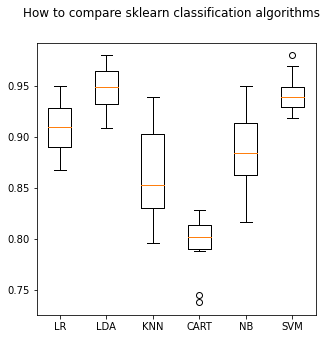

In [38]:
fig = plt.figure(figsize=(5,5))
fig.suptitle('How to compare sklearn classification algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [39]:
results

[array([0.94949495, 0.90909091, 0.90909091, 0.92929293, 0.92857143,
        0.92857143, 0.87755102, 0.86734694, 0.8877551 , 0.89795918]),
 array([0.92929293, 0.96969697, 0.97979798, 0.91919192, 0.94897959,
        0.96938776, 0.90816327, 0.93877551, 0.94897959, 0.94897959]),
 array([0.82828283, 0.7979798 , 0.85858586, 0.92929293, 0.8877551 ,
        0.93877551, 0.84693878, 0.79591837, 0.83673469, 0.90816327]),
 array([0.78787879, 0.73737374, 0.82828283, 0.7979798 , 0.82653061,
        0.80612245, 0.79591837, 0.74489796, 0.80612245, 0.81632653]),
 array([0.88888889, 0.87878788, 0.94949495, 0.8989899 , 0.91836735,
        0.92857143, 0.85714286, 0.81632653, 0.84693878, 0.87755102]),
 array([0.93939394, 0.96969697, 0.97979798, 0.92929293, 0.94897959,
        0.94897959, 0.91836735, 0.92857143, 0.93877551, 0.92857143])]

In [40]:
np.array(results).mean()

0.8902219473648044

In [41]:
print(type(cv_results_mean))
names
pd.DataFrame(zip(names, cv_results_mean), columns=['Models','Results'])

<class 'list'>


Models   Results
0     LR  0.908472
1    LDA  0.946125
2    KNN  0.862843
3   CART  0.794743
4     NB  0.886106
5    SVM  0.943043

<AxesSubplot:ylabel='Models'>

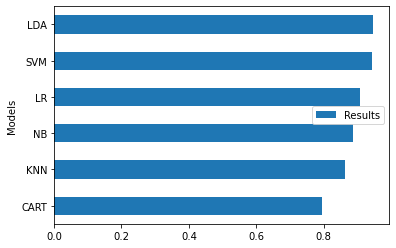

In [42]:
pd.DataFrame(zip(names, cv_results_mean), columns=['Models','Results']).sort_values(by='Results').plot.barh('Models')


### SIN PARAMETRIZAR CASI NADA LOS ALGORÍTMOS, SE OBSERVA QUE UTILIZANDO "Cross_Validation_Score (Separa el conjunto de datos de train, en cjddatos más pequeños, aplica el modelo y obtiene el score seleccionado, xa luego obtener una media de todos los resultados, y definir la precisión media del modelo en este caso "Accuracy")", los 2 modelos que mejor predicen son el SVM (Maquina de vector soporte de clasificación y el LDA (Analisis lineal discriminatorio), según como se relacionan las variables observadas en el pairplot y comparando con la imagen de "https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html", cuadra bastante que esos modelos den buenos resultados.
De todas formas habría que probar XGboost y el AdaBoost

### ADABOOST CLASSIFIER..
- https://www.datacamp.com/tutorial/adaboost-classifier-python

In [56]:
from sklearn.ensemble import AdaBoostClassifier

mod_svc = SVC(kernel='linear', probability=True) # 'Poly'+'degree=xxx','sigmoid',''

mod_adb_svc = AdaBoostClassifier(n_estimators=35, base_estimator=mod_svc, learning_rate=0.2).fit(X_train, y_train)

y_predict_adb_svc_test = mod_adb_svc.predict(X_test)
y_predict_adb_svc_train = mod_adb_svc.predict(X_train)

print('Precisión - Test:', accuracy_score(y_test, y_predict_adb_svc_test))
print('Precisión - Train:', accuracy_score(y_train, y_predict_adb_svc_train))



Precisión - Test: 0.959349593495935
Precisión - Train: 0.9522357723577236


C:\Users\RubenGA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


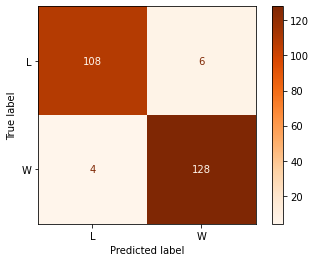

In [57]:
plot_confusion_matrix(mod_adb_svc, X_test, y_test, display_labels=mod_adb_svc.classes_, cmap=plt.cm.Oranges)

In [52]:
? ConfusionMatrixDisplay

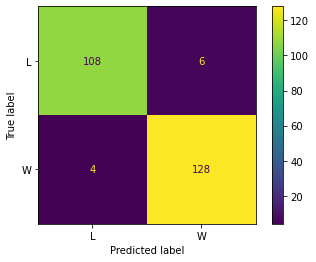

In [58]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_predict_adb_svc_test, labels=mod_adb_svc.classes_,), \
                       display_labels=mod_adb_svc.classes_).plot()

In [47]:
print(os.getcwd())

C:\Users\RubenGA\WorkSpaces_rga01\Python\Notebooks\Practicas_NBA


In [74]:
# Guardar Modelo..
pickle.dump(mod_adb_svc, open("models_ml/Model_adb_svc_4factors1lineXgame.sav", 'wb'))

In [59]:
# pd.DataFrame(zip(mod_adb.predict_proba(X_test),y_test), columns=['L','W','Real'])
pd.DataFrame(mod_adb_svc.predict_proba(X_test), columns=mod_adb_svc.classes_)

L         W
0    0.730296  0.269704
1    0.953577  0.046423
2    0.599092  0.400908
3    0.669522  0.330478
4    0.849657  0.150343
..        ...       ...
241  0.570270  0.429730
242  0.376984  0.623016
243  0.660672  0.339328
244  0.882853  0.117147
245  0.106989  0.893011

[246 rows x 2 columns]

In [62]:
df_predict_proba_adb_svc_test = pd.DataFrame(mod_adb_svc.predict_proba(X_test), columns=mod_adb_svc.classes_)
#df_predict_proba_test.reset_index(drop=True)
df_predict_proba_adb_svc_test.insert(2,'Real',y_test.reset_index(drop=True))
df_predict_proba_adb_svc_test.head()

L         W Real
0  0.730296  0.269704    L
1  0.953577  0.046423    L
2  0.599092  0.400908    L
3  0.669522  0.330478    L
4  0.849657  0.150343    L

In [63]:
# No hace nada
pd.DataFrame(mod_adb_svc.predict_proba(X_test), columns=mod_adb_svc.classes_).insert(2,'Real',y_test.reset_index(drop=True))

In [64]:
df_predict_proba_adb_svc_test.groupby(by='Real').count()

L    W
Real          
L     114  114
W     132  132

In [65]:
df_predict_proba_adb_svc_test.Real.value_counts()

W    132
L    114
Name: Real, dtype: int64

In [66]:
# Predecir..
y_game_predict = mod_adb_svc.predict(X_game)

print("EL Modelo Predice que el Equipo Local", df_00.TEAM_NAME_l[df_00.TEAM_ID_l == 1610612740].unique(),":")
print(y_game_predict,"al equipo Visitante", df_00.TEAM_NAME_l[df_00.TEAM_ID_l == 1610612741].unique(), \
      "Con un % de acierto del", mod_adb.predict_proba(X_game)[0][1] * 100,"%")

EL Modelo Predice que el Equipo Local ['New Orleans Pelicans'] :
['W'] al equipo Visitante ['Chicago Bulls'] Con un % de acierto del 53.750379238923266 %


In [67]:
# Predicción varios games
X_games = pd.DataFrame()
for ind in range(10): # Una de las muchas maneras para formar un conjunto de entradas (correspondiente a Games x jugar)
    print(ind)
    X_local = df_00[df_00.TEAM_ID_l == 1610612740+ind].groupby(by='TEAM_ID_l').mean().iloc[:, 5:13].reset_index(drop=True)
    X_visitante = df_00[df_00.TEAM_ID_v == 1610612741+ind].groupby(by='TEAM_ID_v').mean().iloc[:, 23:31].reset_index(drop=True)

    X_game = pd.concat([X_local,X_visitante], axis=1) # Convierte 2 filas en una sola, concatenado los valores 
    X_games = pd.concat([X_games,X_game], axis=0) # añade la fila a un nuevo DF..

X_games.reset_index(drop=True)


0
1
2
3
4
5
6
7
8
9


EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  OPP_EFG_PCT_l  \
0   0.529780    0.249610      0.138390    0.241683       0.548122   
1   0.545927    0.252976      0.117512    0.194244       0.542293   
2   0.541024    0.251537      0.122634    0.200317       0.509659   
3   0.557488    0.258561      0.133268    0.193951       0.549561   
4   0.560415    0.225902      0.147390    0.208927       0.489268   
5   0.544268    0.283927      0.150512    0.175780       0.553220   
6   0.540049    0.223366      0.140707    0.196951       0.511463   
7   0.537585    0.261439      0.140195    0.191854       0.529756   
8   0.552927    0.260220      0.144341    0.209244       0.531195   
9   0.543390    0.258707      0.125293    0.200732       0.531976   

   OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  EFG_PCT_v  FTA_RATE_v  \
0        0.251756       0.140927        0.258537   0.536634    0.246415   
1        0.246659       0.125488        0.252244   0.537902    0.252146   
2        0.246805       0.138293        0.273024   0.557098    0.232927   
3        0.260488       0.127829        0.235293   0.544439    0.248244   
4        0.272317       0.145683        0.264854   0.525585    0.291878   
5        0.272439       0.135512        0.296098   0.523805    0.231220   
6        0.220268       0.137780        0.287659   0.536293    0.260415   
7        0.266195       0.143098        0.281854   0.544073    0.253463   
8        0.269463       0.152195        0.264049   0.550561    0.260171   
9        0.231244       0.124463        0.246463   0.550415    0.248951   

   TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  OPP_FTA_RATE_v  OPP_TOV_PCT_v  \
0      0.137000    0.171341       0.542098        0.260756       0.133220   
1      0.132829    0.185341       0.534610        0.240293       0.128512   
2      0.153805    0.197561       0.527171        0.240073       0.127683   
3      0.148537    0.195683       0.528732        0.261488       0.139463   
4      0.165561    0.201146       0.556659        0.261317       0.137195   
5      0.131415    0.168098       0.518927        0.218976       0.130488   
6      0.139098    0.185854       0.552000        0.253610       0.127122   
7      0.149317    0.203024       0.519732        0.273683       0.148756   
8      0.135805    0.205512       0.542439        0.212195       0.130146   
9      0.136634    0.212805       0.562902        0.302585       0.158415   

   OPP_OREB_PCT_v  
0        0.270976  
1        0.256878  
2        0.256976  
3        0.256463  
4        0.283146  
5        0.297073  
6        0.270610  
7        0.262976  
8        0.255878  
9        0.299171

In [68]:
df_predict_games = pd.DataFrame(mod_adb_svc.predict_proba(X_games), columns=mod_adb_svc.classes_)
#df_predict_proba_test.reset_index(drop=True)
df_predict_games.insert(2,'Predict',mod_adb_svc.predict(X_games))
df_predict_games

L         W Predict
0  0.462782  0.537218       W
1  0.483447  0.516553       W
2  0.456782  0.543218       W
3  0.486220  0.513780       W
4  0.307836  0.692164       W
5  0.565092  0.434908       L
6  0.438802  0.561198       W
7  0.548563  0.451437       L
8  0.480369  0.519631       W
9  0.438178  0.561822       W

In [69]:
# Una de las muchas maneras de ponder en contexto los resultados del modelo, con los Nombres de los Teams que jugaran
# los partidos
Team_local = []
Team_visitante = []
for ind in df_predict_games.index:
    print(ind)
    Team_local.append(str(df_00.TEAM_NAME_l[df_00.TEAM_ID_l == 1610612740+ind].unique()))
    Team_visitante.append(str(df_00.TEAM_NAME_v[df_00.TEAM_ID_v == 1610612741+ind].unique()))
print(Team_local,'\n',Team_visitante)

df_predict_games.insert(0,'Team_local', pd.Series(Team_local))
df_predict_games.insert(1,'Team_visitante', pd.Series(Team_visitante))

0
1
2
3
4
5
6
7
8
9
["['New Orleans Pelicans']", "['Chicago Bulls']", "['Dallas Mavericks']", "['Denver Nuggets']", "['Golden State Warriors']", "['Houston Rockets']", "['LA Clippers']", "['Los Angeles Lakers']", "['Miami Heat']", "['Milwaukee Bucks']"] 
 ["['Chicago Bulls']", "['Dallas Mavericks']", "['Denver Nuggets']", "['Golden State Warriors']", "['Houston Rockets']", "['LA Clippers']", "['Los Angeles Lakers']", "['Miami Heat']", "['Milwaukee Bucks']", "['Minnesota Timberwolves']"]


In [70]:
# La predicción decide en función del %probabilidad del modelo para Win y Lost, si el equipo Local Gana(W) o Pierde(L)
df_predict_games

Team_local              Team_visitante         L         W  \
0   ['New Orleans Pelicans']           ['Chicago Bulls']  0.462782  0.537218   
1          ['Chicago Bulls']        ['Dallas Mavericks']  0.483447  0.516553   
2       ['Dallas Mavericks']          ['Denver Nuggets']  0.456782  0.543218   
3         ['Denver Nuggets']   ['Golden State Warriors']  0.486220  0.513780   
4  ['Golden State Warriors']         ['Houston Rockets']  0.307836  0.692164   
5        ['Houston Rockets']             ['LA Clippers']  0.565092  0.434908   
6            ['LA Clippers']      ['Los Angeles Lakers']  0.438802  0.561198   
7     ['Los Angeles Lakers']              ['Miami Heat']  0.548563  0.451437   
8             ['Miami Heat']         ['Milwaukee Bucks']  0.480369  0.519631   
9        ['Milwaukee Bucks']  ['Minnesota Timberwolves']  0.438178  0.561822   

  Predict  
0       W  
1       W  
2       W  
3       W  
4       W  
5       L  
6       W  
7       L  
8       W  
9       W

In [326]:
df_00.head()
X_test[:5]

EFG_PCT_l  FTA_RATE_l  TM_TOV_PCT_l  OREB_PCT_l  OPP_EFG_PCT_l  \
501       0.534       0.292         0.101       0.220          0.638   
992       0.398       0.323         0.183       0.258          0.659   
880       0.443       0.181         0.075       0.224          0.490   
517       0.366       0.109         0.086       0.313          0.475   
1022      0.556       0.211         0.174       0.265          0.648   

      OPP_FTA_RATE_l  OPP_TOV_PCT_l  OPP_OREB_PCT_l  EFG_PCT_v  FTA_RATE_v  \
501            0.149          0.099           0.244      0.638       0.149   
992            0.187          0.119           0.244      0.659       0.187   
880            0.224          0.130           0.328      0.490       0.224   
517            0.210          0.168           0.388      0.475       0.210   
1022           0.231          0.061           0.182      0.648       0.231   

      TM_TOV_PCT_v  OREB_PCT_v  OPP_EFG_PCT_v  OPP_FTA_RATE_v  OPP_TOV_PCT_v  \
501          0.099       0.200          0.534           0.292          0.101   
992          0.119       0.222          0.398           0.323          0.183   
880          0.130       0.241          0.443           0.181          0.075   
517          0.168       0.184          0.366           0.109          0.086   
1022         0.061       0.182          0.556           0.211          0.174   

      OPP_OREB_PCT_v  
501            0.280  
992            0.439  
880            0.299  
517            0.388  
1022           0.367

### Conclusiones y trabajo futuro.
- Se han utilizado las stadisticas de los 4factors para obtener un modelo predicitivo de clasificación supervisado binario con respecto a la victoria(W) o la derrota(L) de los equipos que juegaron como local durante toda la temporada regular 2021-22, utilizando dichas estadisticas de los 1230 partidos disputados..*** Se podría entrenar el modelo para predecir la W - L del equipo Visitante, solamente habria que cambiar la variable objetivo utilizada para entrenar los modelos, en vez de por "WL_l", por "WL_v". TB se podrian añadir las estadisticas tradicionales de "..PCT..", para ver si mejoramos los modelos**
- Se observa que podemos utilizar esta misma información Preprocesada y analizada (Para darle un contexto lo más intuitivo posible, habiendo transformado y seleccionado los mejores datos para este tipo de modelos de manera manual (se podría realizar algún tipo de técnica para seleccionar las mejores var.predictoras en función de sus correlaciones y relación con la var.objetivo..), para obtener la puntuación del equipo local y tb visitante utilizando modelos de regresión lineal Supervisada.
**** De primeras predecimos las var.objetivo para el equipo local, debido a que jugar en casa tiene un factor bastante determinante para este tipo de competición (No existe una var. objetivamente hablando, que defina este atributo para entrenar el modelo, lo cual da que pensar, y para un futuro trabajo se podría calcular un valor para cada equipo el cual refleje y se incorpore como var.predictora, el impacto del equipo jugando en casa.**
**** Decir que los modelos se entrenan con las estadísticas obtenidas de cada game de la competición (1230 encuentros [82*30]), y para predecir un game futuro, se obtiene la media de cada equipo diferenciando si juega como local o visitante, para realizar el "input" al modelo.**
- links interesantes..  
https://towardsdatascience.com/a-journey-through-xgboost-milestone-2-f3410109be5a  
https://shapash.readthedocs.io/en/latest/overview.html#getting-started-3-minutes-to-shapash  
https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/ Binary Clasification con redes neuronales..